In [86]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import init_notebook_mode, plot
init_notebook_mode(connected=True)
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from scipy.stats import uniform

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2


In [2]:
validation = pd.read_csv("occupancy+detection/datatest.txt", sep=',')
test = pd.read_csv("occupancy+detection/datatest2.txt", sep=',')
train = pd.read_csv('occupancy+detection/datatraining.txt', sep=',')

In [3]:
train.head(2)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1


In [4]:
train['date'] = pd.to_datetime(train['date'])
validation['date'] = pd.to_datetime(validation['date'])
test['date'] = pd.to_datetime(test['date'])
train.set_index('date', inplace=True)
validation.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [5]:
print(train.shape, validation.shape, test.shape)

(8143, 6) (2665, 6) (9752, 6)


In [6]:
train.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


- Temperature in Celsius.
- Relative humidity as a percentage.
- Light measured in lux.
- Carbon dioxide measured in parts per million.
- Humidity ratio, derived from temperature and relative humidity measured in kilograms of water vapor per kilogram of air.-
- Occupancy as either 1 for occupied or 0 for not occupied.

In [7]:
validation.head(2)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:19:00,23.700,26.272,585.2,749.2,0.004764,1
2015-02-02 14:19:59,23.718,26.290,578.4,760.4,0.004773,1


In [8]:
test.head(2)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-11 14:48:00,21.76,31.133333,437.333333,1029.666667,0.005021,1
2015-02-11 14:49:00,21.79,31.000000,437.333333,1000.000000,0.005009,1


In [9]:
train.isna().sum()

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [10]:
train.Occupancy.value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

Text(0.5, 1.0, 'Target distribution')

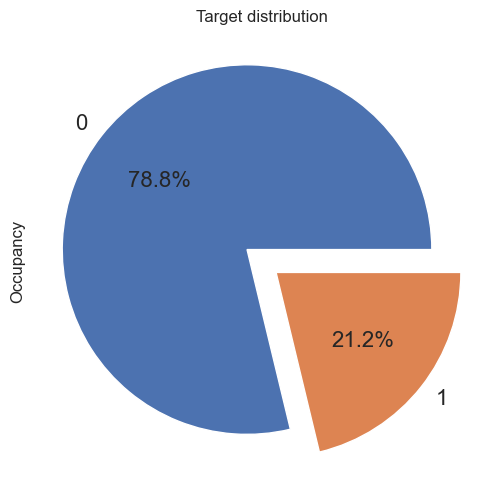

In [11]:
# Plotting target distribution 
plt.figure(figsize=(6,6))
train['Occupancy'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%' ,textprops={'fontsize':16}).set_title("Target distribution")

Imbalanced class

In [12]:
train.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


some column values are low, some column values are high

In [13]:
train.columns

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

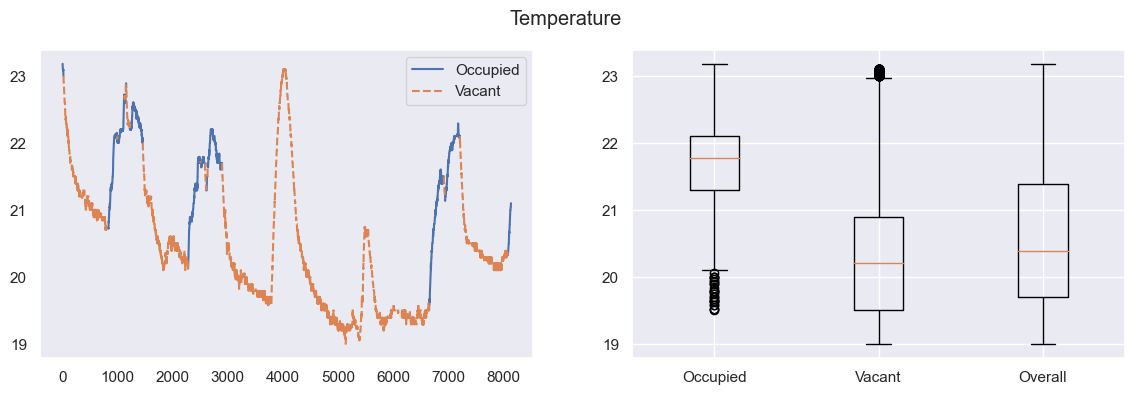

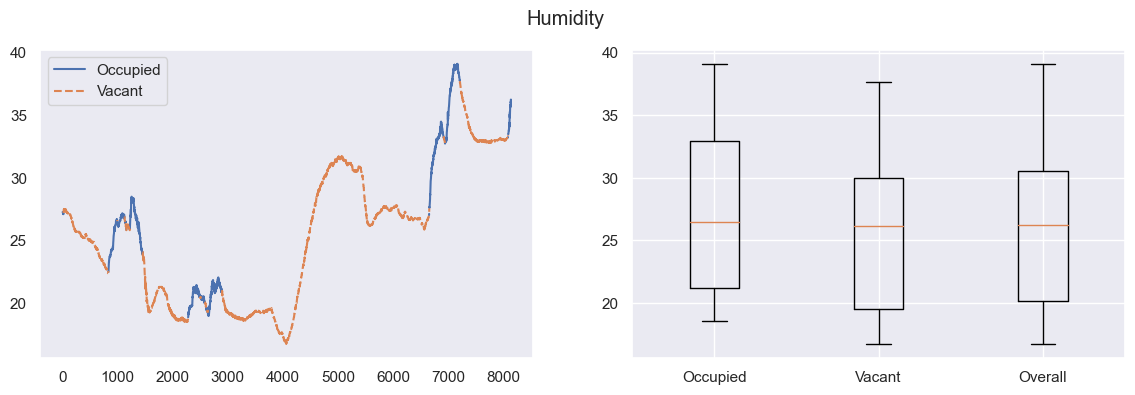

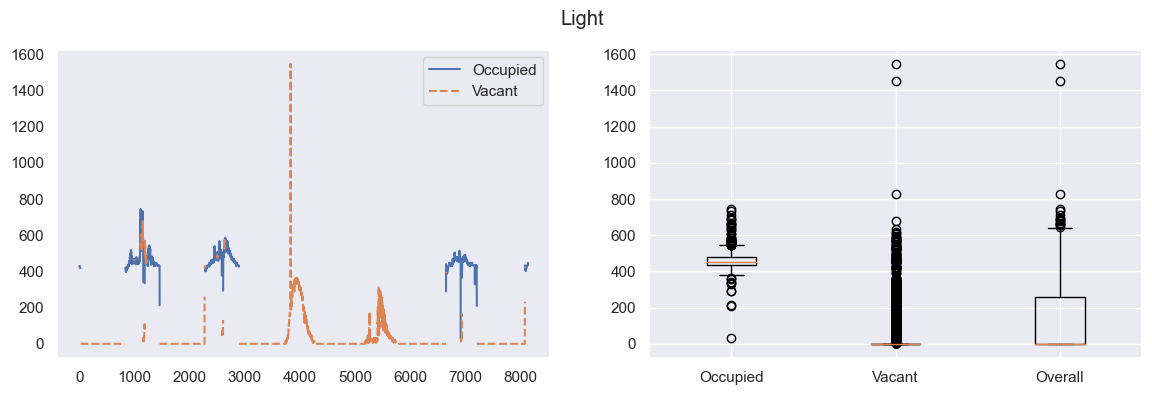

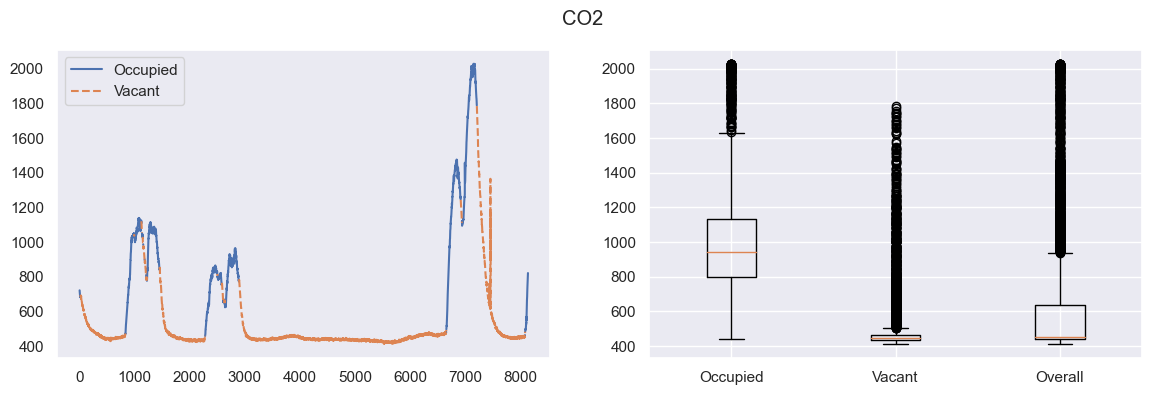

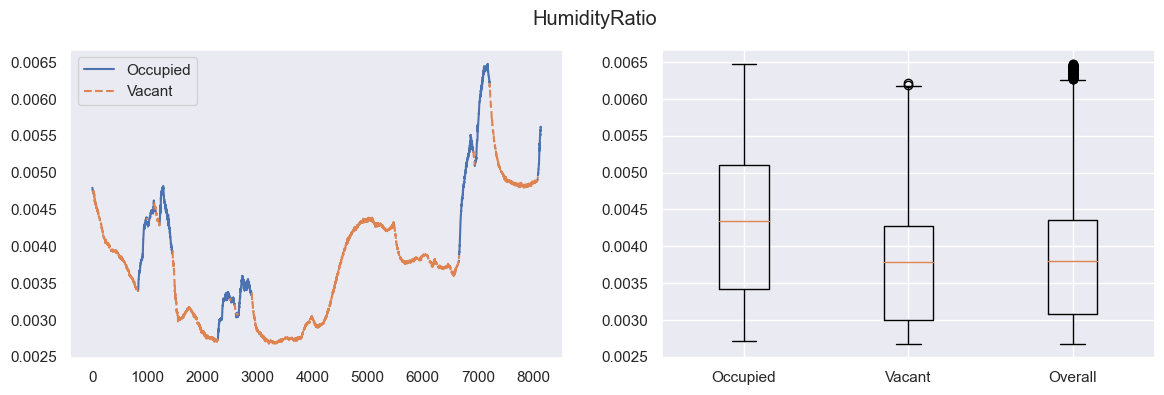

In [14]:
def occupancy_plot(df, cat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    
    fig.suptitle(cat)
    ax1.plot(np.where(df.Occupancy==1, df[cat], None), label='Occupied')
    ax1.plot(np.where(df.Occupancy==0, df[cat], None), label='Vacant', ls='--')
    ax1.grid()
    ax1.legend()
    
    ax2.boxplot([df[cat][df.Occupancy==1], df[cat][df.Occupancy==0], df[cat]])
    ax2.set_xticklabels(['Occupied', 'Vacant', 'Overall'])


for i in range(0, 5):
    occupancy_plot(train, train.columns[i])

### Outlier Handling
The Empirical Rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean. Under this rule, 68% of the data falls within one standard deviation, 95% percent within two standard deviations, and 99.7% within three standard deviations from the mean. Z-scores represent the number of standard deviations a data point is away from the mean.

In [15]:
train.shape

(8143, 6)

In [16]:
from scipy import stats

z_scores = stats.zscore(train)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train = train[filtered_entries]
train.shape

(7926, 6)

In [18]:
train.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,7926.000000,7926.000000,7926.000000,7926.000000,7926.000000,7926.000000
mean,20.580918,25.403866,111.569184,572.861650,0.003799,0.193793
std,1.003361,5.215692,189.112536,239.738295,0.000767,0.395293
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.037500,0.000000,439.000000,0.003064,0.000000
50%,20.390000,26.100000,0.000000,452.500000,0.003789,0.000000
75%,21.290000,29.716875,147.875000,589.687500,0.004326,0.000000
max,23.180000,37.000000,696.500000,1545.666667,0.005954,1.000000


<Axes: >

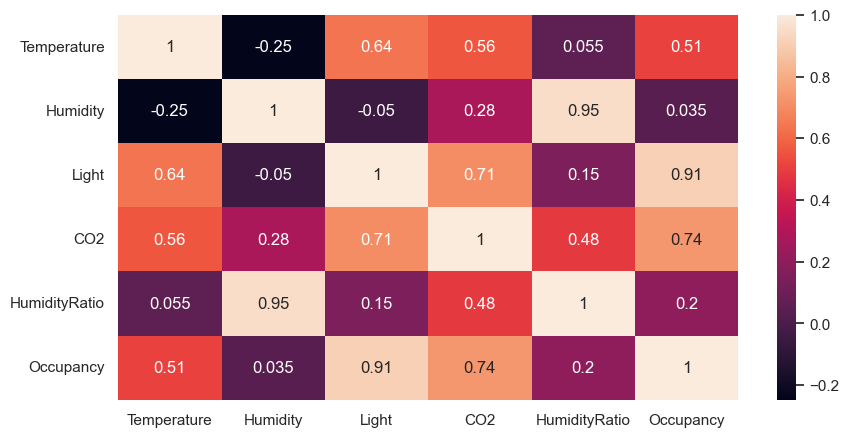

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(),annot=True)

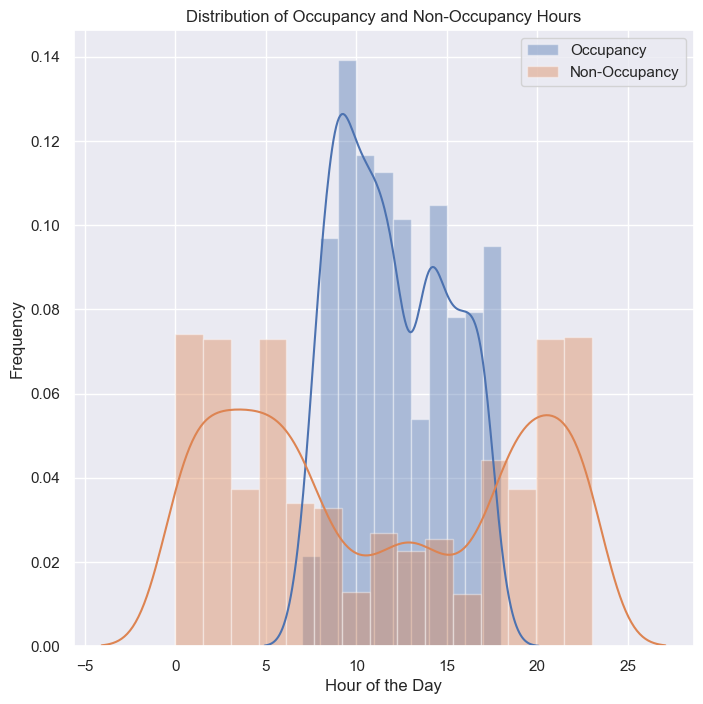

In [25]:
# Extract hours for occupancy and non-occupancy from the 'date' index
hours_1 = train[train['Occupancy'] == 1].index.hour
hours_0 = train[train['Occupancy'] == 0].index.hour

# Create the distribution plots
plt.figure(figsize=(8, 8))
ax = sns.distplot(hours_1, label='Occupancy', kde=True)
ax = sns.distplot(hours_0, label='Non-Occupancy', kde=True)

plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Distribution of Occupancy and Non-Occupancy Hours')
plt.legend()
plt.show()

Between 07:00 and 18:00 there are occupants in the environment.

In [20]:
train.index.values

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.250000,0.004793,1
1,23.15,27.2675,429.5,714.000000,0.004783,1
2,23.15,27.2450,426.0,713.500000,0.004779,1
3,23.15,27.2000,426.0,708.250000,0.004772,1
4,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...
7921,21.05,36.0975,433.0,787.250000,0.005579,1
7922,21.05,35.9950,433.0,789.500000,0.005563,1
7923,21.10,36.0950,433.0,798.500000,0.005596,1
7924,21.10,36.2600,433.0,820.333333,0.005621,1


In [27]:
'''This code will add a new column 'period_of_day' to each dataset, indicating whether the timestamp falls within
the specified period (7 AM to 5 PM(17:00)) with '1' representing the period and '0' representing outside the period'''

train['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in train.index]
validation['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in validation.index]
test['period_of_day'] = [1 if (i.hour >= 7 and i.hour <= 17) else 0 for i in test.index]

train.sample(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,period_of_day
date,,,,,,,
2015-02-07 12:48:00,23.100,17.166667,302.000000,446.000000,0.002994,0,1
2015-02-09 04:46:00,19.290,26.890000,0.000000,459.000000,0.003716,0,0
2015-02-09 01:38:00,19.390,27.200000,0.000000,460.000000,0.003783,0,0
2015-02-08 10:45:00,19.230,30.533333,17.333333,433.000000,0.004207,0,1
2015-02-06 14:44:59,22.200,20.722500,530.500000,827.000000,0.003424,1,1
2015-02-08 01:24:00,19.500,30.100000,0.000000,434.000000,0.004218,0,0
2015-02-09 22:14:59,20.500,33.290000,0.000000,622.000000,0.004969,0,0
2015-02-09 22:09:59,20.445,33.290000,0.000000,619.000000,0.004952,0,0
2015-02-08 10:31:00,19.290,30.533333,24.000000,427.666667,0.004223,0,1


In [28]:
# For training data
X_train = train.drop(columns=['Occupancy'])
y_train = train['Occupancy']

# For validation data
X_validation = validation.drop(columns=['Occupancy'])
y_validation = validation['Occupancy']

# For test data
X_test = test.drop(columns=['Occupancy'])
y_test = test['Occupancy']


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)


In [30]:
print(X_train_scaled.shape,y_train.shape, X_validation_scaled.shape,y_validation.shape, X_test_scaled.shape, y_test.shape)

(7926, 6) (7926,) (2665, 6) (2665,) (9752, 6) (9752,)


### Extra Trees Classifier

In [43]:
# The number of trees in the forest algorithm
n_estimators = [50, 100, 300, 500, 1000]

# The minimum number of samples required to split an internal node, default value is 2.
min_samples_split = [2, 3, 5, 7, 9]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split
max_features = ['sqrt', 'log2', None] 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

best_model = ExtraTreesClassifier(random_state=42)

random_cv = RandomizedSearchCV(estimator=best_model,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=20, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               random_state=42)
random_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 5, 7, 9],
                                        'n_estimators': [50, 100, 300, 500,
                                                         1000]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [44]:
random_cv.best_estimator_

ExtraTreesClassifier(min_samples_leaf=8, min_samples_split=7, n_estimators=1000,
                     random_state=42)

                   Model  Accuracy  F1 Score       ROC
0  Extra Tree Classifier  0.978612  0.971457  0.988946


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665



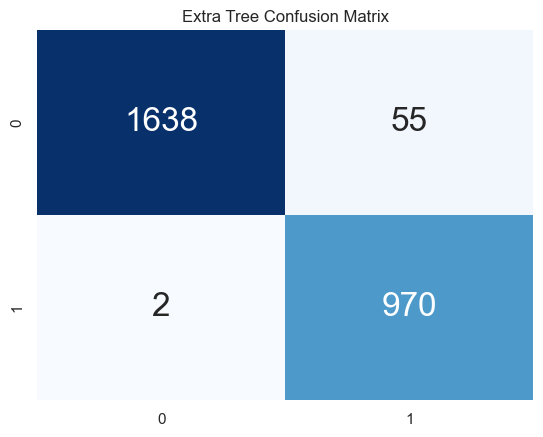

In [79]:
xtree = ExtraTreesClassifier(min_samples_leaf=8, min_samples_split=7, n_estimators=1000,
                     random_state=42)
predictor_xtree = xtree.fit(X_train_scaled, y_train)
y_pred = predictor_xtree.predict(X_validation_scaled)

acc_xt = accuracy_score(y_validation, y_pred)
roc = roc_auc_score(y_validation, predictor_xtree.predict_proba(X_validation_scaled)[:, 1])
f1_xt= f1_score(y_validation, y_pred)

results = pd.DataFrame([['Extra Tree Classifier',acc_xt, f1_xt,roc]], columns = ['Model', 'Accuracy','F1 Score','ROC'])
print(results)
print('\n')
cm_xgb = confusion_matrix(y_validation, y_pred)
plt.title("Extra Tree Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
print (classification_report(y_validation, y_pred))

### XGBoost

     Model  Accuracy  F1 Score       ROC
0  xgboost   0.94409  0.921785  0.989906


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1693
           1       0.94      0.90      0.92       972

    accuracy                           0.94      2665
   macro avg       0.94      0.94      0.94      2665
weighted avg       0.94      0.94      0.94      2665



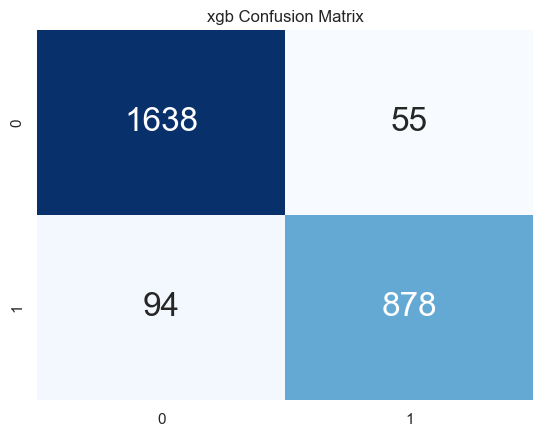

In [67]:
xgbc = xgb.XGBClassifier(random_state=42)
predictor_xgb = xgbc.fit(X_train_scaled, y_train)
y_pred = predictor_xgb.predict(X_validation_scaled)

acc_xgb = accuracy_score(y_validation, y_pred)
roc = roc_auc_score(y_validation, xgbc.predict_proba(X_validation_scaled)[:, 1])
f1_xgb= f1_score(y_validation, y_pred)

results = pd.DataFrame([['xgboost',acc_xgb, f1_xgb,roc]], columns = ['Model', 'Accuracy','F1 Score','ROC'])
print(results)
print('\n')
cm_xgb = confusion_matrix(y_validation, y_pred)
plt.title("xgb Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
print (classification_report(y_validation, y_pred))

### Simple Feedforward Neural Network 

In [57]:
def create_model(optimizer='rmsprop', dropout_rate=0.3, l2_rate=0.01):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=6, kernel_regularizer=l2(l=l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(l=l2_rate)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_classifier = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

param_dist = {
    'optimizer': ['rmsprop', 'adam'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'l2_rate': [0.01, 0.001, 0.0001]
}

# Initialize RandomizedSearchCV with the Keras model and hyperparameter space
random_search = RandomizedSearchCV(estimator=model_classifier,
                                   param_distributions=param_dist,
                                   n_iter=10,  
                                   cv=5,      
                                   scoring='accuracy',
                                   verbose=1,
                                   n_jobs=-1 
                                   )

# Perform the RandomizedSearchCV on the training data
random_search_result = random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and best model
best_params = random_search_result.best_params_
best_model = random_search_result.best_estimator_.model



Fitting 5 folds for each of 10 candidates, totalling 50 fits


2023-08-07 18:17:03.843303: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.854842: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.863919: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.864245: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.864986: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.868505: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.871837: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-07 18:17:03.872467: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


50/50 [==============================] - 0s 330us/step


2023-08-07 18:19:10.763566: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [62]:
best_params

{'optimizer': 'rmsprop', 'l2_rate': 0.01, 'dropout_rate': 0.3}

84/84 [==============================] - 0s 368us/step
Accuracy Score:  0.9782363977485928
F1 Score:  0.9709418837675351
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665

Confusion Matrix:


<Axes: >

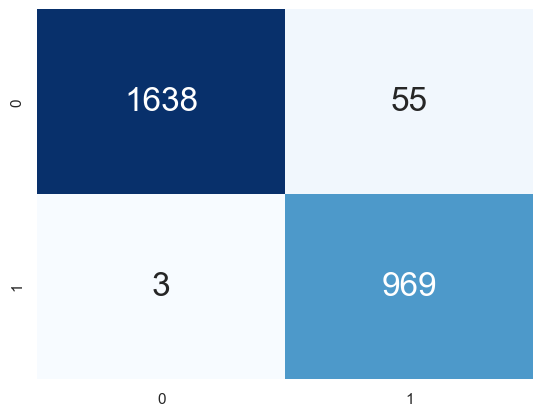

In [83]:
# Predict on the validation set
y_pred = best_model.predict(X_validation_scaled)
threshold = 0.5
y_pred = [1 if i >= threshold else 0 for i in y_pred]

accuracy_fnn = accuracy_score(y_validation, y_pred)
print("Accuracy Score: ", accuracy_fnn)

f1_fnn = f1_score(y_validation, y_pred)
print("F1 Score: ", f1_fnn)

class_report = classification_report(y_validation, y_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_validation, y_pred)
print("Confusion Matrix:")
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

### Comparison of scores on validation set

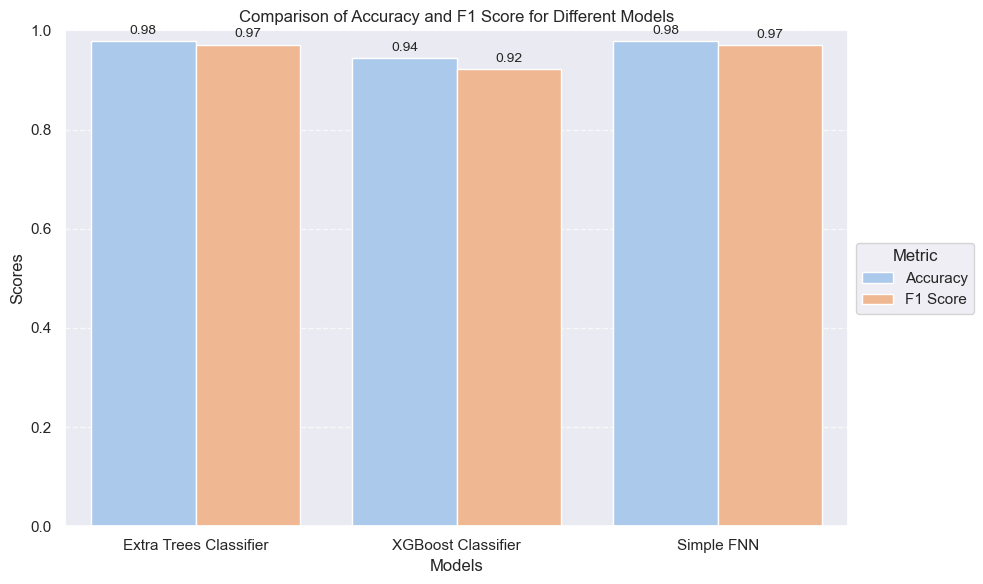

In [80]:
models = ['Extra Trees Classifier', 'XGBoost Classifier', 'Simple FNN']
acc_scores = [acc_xt, acc_xgb, accuracy_fnn]
f1_scores = [f1_xt, f1_xgb, f1_fnn]

# Create a DataFrame to hold the scores
data = pd.DataFrame({'Models': models, 'Accuracy': acc_scores, 'F1 Score': f1_scores})
data_melted = pd.melt(data, id_vars='Models', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Models', y='Score', hue='Metric', data=data_melted, palette='pastel')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Accuracy and F1 Score for Different Models')
plt.ylim(0, 1)
plt.legend(title='Metric', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the score values above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10, xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()



### Applying on test data

In [82]:
#Extra Tree

                   Model  Accuracy  F1 Score       ROC
0  Extra Tree Classifier  0.978466  0.951095  0.996492


              precision    recall  f1-score   support

           0       1.00      0.97      0.99      7703
           1       0.91      1.00      0.95      2049

    accuracy                           0.98      9752
   macro avg       0.95      0.99      0.97      9752
weighted avg       0.98      0.98      0.98      9752



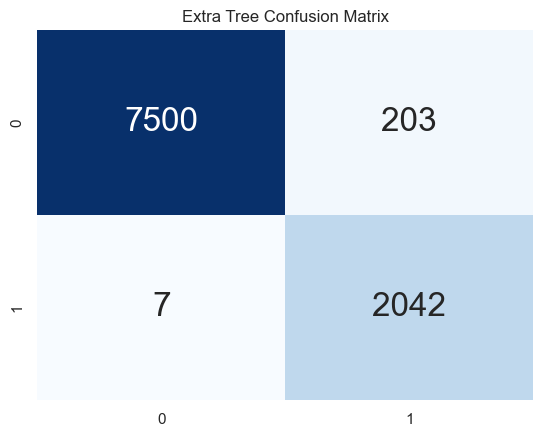

In [81]:
y_pred = predictor_xtree.predict(X_test_scaled)

acc_xt = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, predictor_xtree.predict_proba(X_test_scaled)[:, 1])
f1_xt= f1_score(y_test, y_pred)

results = pd.DataFrame([['Extra Tree Classifier',acc_xt, f1_xt,roc]], columns = ['Model', 'Accuracy','F1 Score','ROC'])
print(results)
print('\n')
cm_xgb = confusion_matrix(y_test, y_pred)
plt.title("Extra Tree Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
print (classification_report(y_test, y_pred))

305/305 [==============================] - 0s 354us/step
Accuracy Score:  0.978363412633306
F1 Score:  0.950804383306132
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      7703
           1       0.91      1.00      0.95      2049

    accuracy                           0.98      9752
   macro avg       0.95      0.98      0.97      9752
weighted avg       0.98      0.98      0.98      9752

Confusion Matrix:


<Axes: >

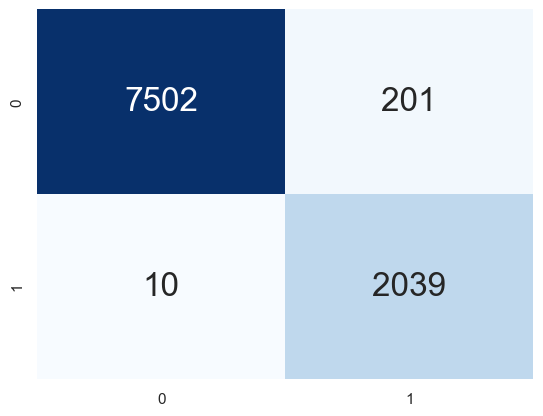

In [84]:
# Simple FNN
y_pred = best_model.predict(X_test_scaled)
y_pred = [1 if i >= threshold else 0 for i in y_pred]

accuracy_fnn = accuracy_score(y_test, y_pred)
print("Accuracy Score: ", accuracy_fnn)

f1_fnn = f1_score(y_test, y_pred)
print("F1 Score: ", f1_fnn)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

## Comparison of models on test set


| Model                 | Accuracy   | F1 Score   |
| --------------------- | ---------- | ---------- |
| ExtraTreesClassifier  | 0.978466   | 0.951095   |
| Simple FNN            | 0.978363   | 0.950804   |


                                    Both model performed well on unseen test data